# Flying Mantines

ModSim Project 3

Lydia Hodges and Chase Joyner

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
%matplotlib inline

from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

In [36]:
angle = 90 * degree

condition_m = Condition(x = 0 * m, 
                      y = 0 * m,
                      g = 9.8 * m/s**2,
                      diameter = 6.7 * m,
                      mass = 1350 * kg,
                      rho = 1.2 * kg/m**3,
                      angle = angle,
                      den = 1000 * kg/m**3,
                      C_d = 1.28 * np.sin(np.deg2rad(angle)),
                      C_l = 2 * np.pi * np.deg2rad(angle),
                      wing_area = 14.14 * m**2,
                      velocity = 9.83 * m / s,
                      bh = 4.9 * m,
                      duration = 2.5 * s)
angle_array = linrange(60, 90, 1)

In [37]:
condition_p = Condition(x = 14 * m,
                        y = 4.9 * m,
                        velocity = -11.18 * m/s,
                        mass = 70 * kg,
                        angle = 0 * degree,
                        density = 985 * kg/m**2,
                        duration = 1 * s,
                        diameter = 0.18 * m)

In [38]:
def make_system(condition):
    
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

In [39]:
system = make_system(condition_m)
system_2 = make_system(condition_p)

In [40]:
def slope_func_p(state, t, system):
    
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    ax = 0 * m**2
    ay = 0 * m**2
    
    return vx, vy, ax, ay

In [41]:
slope_func_p(system_2.init, 0, system_2)

(<Quantity(-11.18, 'meter / second')>,
 <Quantity(-0.0, 'meter / second')>,
 <Quantity(0, 'meter ** 2')>,
 <Quantity(0, 'meter ** 2')>)

In [42]:
run_odeint(system_2, slope_func_p)
print(system_2.results)

            x    y     vx   vy
0.00  14.0000  4.9 -11.18 -0.0
0.01  13.8882  4.9 -11.18  0.0
0.02  13.7764  4.9 -11.18  0.0
0.03  13.6646  4.9 -11.18  0.0
0.04  13.5528  4.9 -11.18  0.0
0.05  13.4410  4.9 -11.18  0.0
0.06  13.3292  4.9 -11.18  0.0
0.07  13.2174  4.9 -11.18  0.0
0.08  13.1056  4.9 -11.18  0.0
0.09  12.9938  4.9 -11.18  0.0
0.10  12.8820  4.9 -11.18  0.0
0.11  12.7702  4.9 -11.18  0.0
0.12  12.6584  4.9 -11.18  0.0
0.13  12.5466  4.9 -11.18  0.0
0.14  12.4348  4.9 -11.18  0.0
0.15  12.3230  4.9 -11.18  0.0
0.16  12.2112  4.9 -11.18  0.0
0.17  12.0994  4.9 -11.18  0.0
0.18  11.9876  4.9 -11.18  0.0
0.19  11.8758  4.9 -11.18  0.0
0.20  11.7640  4.9 -11.18  0.0
0.21  11.6522  4.9 -11.18  0.0
0.22  11.5404  4.9 -11.18  0.0
0.23  11.4286  4.9 -11.18  0.0
0.24  11.3168  4.9 -11.18  0.0
0.25  11.2050  4.9 -11.18  0.0
0.26  11.0932  4.9 -11.18  0.0
0.27  10.9814  4.9 -11.18  0.0
0.28  10.8696  4.9 -11.18  0.0
0.29  10.7578  4.9 -11.18  0.0
...       ...  ...    ...  ...
0.71   6

In [43]:
def slope_func_m(state, t, system):
    
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -C_d * wing_area * rho * (v**2 / 2)
    a_drag = f_drag / mass
    
    f_lift = C_l * wing_area * rho * (v**2 / 2)
    a_lift = f_lift / mass
    
    a = a_grav + a_drag + a_lift
    
    #print(mass, C_l, a_lift, C_d, a_drag)
    
    return vx, vy, a.x, a.y

In [44]:
slope_func_m(system.init, 0, system)

(<Quantity(6.019139017809241e-16, 'meter / second')>,
 <Quantity(9.83, 'meter / second')>,
 <Quantity(1.955729567972885e-32, 'meter / second ** 2')>,
 <Quantity(-4.583885818029482, 'meter / second ** 2')>)

In [45]:
run_odeint(system, slope_func_m)
print(system.results)

                  x         y            vx        vy
0.000  0.000000e+00  0.000000  6.019139e-16  9.830000
0.025  1.504785e-17  0.244305  6.019139e-16  9.713875
0.050  3.009570e-17  0.485668  6.019139e-16  9.594666
0.075  4.514354e-17  0.724012  6.019139e-16  9.472329
0.100  6.019139e-17  0.959258  6.019139e-16  9.346824
0.125  7.523924e-17  1.191327  6.019139e-16  9.218113
0.150  9.028709e-17  1.420137  6.019139e-16  9.086160
0.175  1.053349e-16  1.645607  6.019139e-16  8.950931
0.200  1.203828e-16  1.867656  6.019139e-16  8.812396
0.225  1.354306e-16  2.086199  6.019139e-16  8.670526
0.250  1.504785e-16  2.301154  6.019139e-16  8.525297
0.275  1.655263e-16  2.512436  6.019139e-16  8.376688
0.300  1.805742e-16  2.719960  6.019139e-16  8.224681
0.325  1.956220e-16  2.923642  6.019139e-16  8.069262
0.350  2.106699e-16  3.123395  6.019139e-16  7.910421
0.375  2.257177e-16  3.319134  6.019139e-16  7.748152
0.400  2.407656e-16  3.510774  6.019139e-16  7.582455
0.425  2.558134e-16  3.69822

Saving figure to file Proj3_SingleRun.pdf


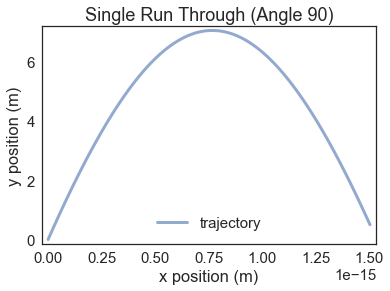

In [46]:
xs = system.results.x
ys = system.results.y
newfig()
plot(xs, ys, label='trajectory')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
        title='Single Run Through (Angle 90)')
savefig('Proj3_SingleRun.pdf')

In [22]:
def sweep_param(angle_array, system):
    newfig()
    plot((0, 6), (4.9, 4.9), 'k')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Sweep Angle (60 - 90)')
    for ang in angle_array:
        condition_m.set(angle=ang)
        system = make_system(condition_m)
        run_odeint(system, slope_func_m)
        xs = system.results.x
        ys = system.results.y
        plot(xs, ys)
    savefig('Proj3_SweepAngle.pdf')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Saving figure to file Proj3_SweepAngle.pdf


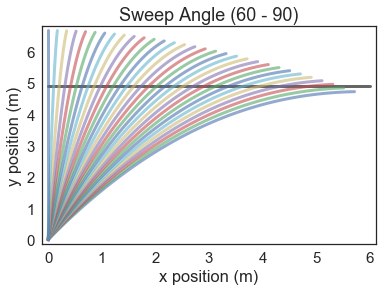

In [23]:
sweep_param(angle_array, system)

In [86]:
def run_sim(state, system, angle_array):
    
    f_table = []
    
    for ang in angle_array:
        condition_m.set(angle=ang)
        system = make_system(condition_m)
        run_odeint(system, slope_func_m)
        h = system.results.y.loc(4.9)
        f = slope_func_m(system.init, h, system)
        acc = sqrt((f[2])**2 + (f[3])**2)
        force = mass * acc
        f_table.append(force)
    return f_table
        #print('angle =', angle, 'force =', force)

In [ ]:
sim = run_sim(system.init, system, angle_array)

In [ ]:
almost_done = Series(sim, angle_array)

In [102]:
#print(almost_done)
newfig()
plot(almost_done, ':', color='blue', label='forces')
decorate(xlabel='Force (N)',
         ylabel='Angle (degrees)',
         title='Force at Point of Impact for Different Angles')

ValueError: setting an array element with a sequence.

ValueError: setting an array element with a sequence.

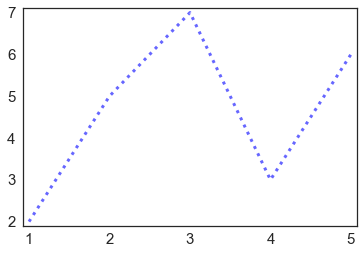

In [94]:
# This is just testing to see how 'Series' works
rand = [2, 5, 7, 3, 6]
what = [1, 2, 3, 4, 5]
series = Series(rand, what)
plot(series, ':', color='blue', label='forces')